In [9]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

output_nums=1


# 修改后的createXY函数
def createXY(dataset: pd.DataFrame, n_past: int, n_future: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset.iloc[i:i + n_future][column_target].values)
    return np.array(dataX), np.array(dataY)

# 修改后的process_files函数
def process_files(columns_all, column_target, folder_path, n_past=1, n_future=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, n_future, column_target)
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.vstack([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY

# 'carbohydrate','protein','fat','cellulose'
columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)','carbohydrate','protein','fat','cellulose']
# columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)']
column_target = ['CGM (mg / dl)']
folder_path = './diabetes_datasets/T1'

# 使用n_past=8, n_future=4调用process_files
n_past=8
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=n_past, n_future=output_nums)



In [11]:
dataX.shape

(15567, 8, 6)

In [12]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
from torch.utils.data import Subset

# 假设dataX和dataY是你的数据
# 将它们转换为PyTorch张量，这里假设它们已经是Tensor或者从Numpy转换过来的
dataX_tensor = torch.tensor(dataX, dtype=torch.float32)
dataY_tensor = torch.tensor(dataY, dtype=torch.float32)

# 创建TensorDataset对象
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# 其余拆分数据集、创建DataLoader对象的代码与之前相同
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)


# # 随机拆分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

assert train_size + val_size + test_size == len(dataset)
# 按照顺序划分数据集
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 8
# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_nums = dataX.shape[2]


In [13]:
# 修改后的LSTMRegressor类
class LSTMRegressor(nn.Module):
    def __init__(self, num_units=6, dropout=0.2, output_size=output_nums):
        super(LSTMRegressor, self).__init__()
        self.lstm1 = nn.LSTM(input_size=feature_nums, hidden_size=num_units, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(in_features=num_units, out_features=output_size)
    
    def forward(self, X):
        X, _ = self.lstm1(X)
        X = self.dropout(X)
        X = X[:, -1, :]  # Get the last sequence output
        X = self.dense(X)
        return X

In [14]:
model = LSTMRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 早停法参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0
max_epochs = 5000

for epoch in range(max_epochs):
    train_loss = 0
    model.train()
    
    # Training loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # 每个epoch后，在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(-1)  # 调整目标尺寸
            output = model(data)
            val_loss += criterion(output, target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch}: Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # 早停法逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最好的模型状态
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        model.load_state_dict(best_model_state)
        break



Epoch 0: Training Loss: 31444.66884247244, Validation Loss: 27740.58620730669
Epoch 1: Training Loss: 29553.407802843067, Validation Loss: 26046.453077110877
Epoch 2: Training Loss: 27922.861915274843, Validation Loss: 24579.851437143177
Epoch 3: Training Loss: 26416.330020408106, Validation Loss: 23194.323825777494
Epoch 4: Training Loss: 24961.925895978326, Validation Loss: 21874.732496916942
Epoch 5: Training Loss: 23585.903286326422, Validation Loss: 20617.06556909023
Epoch 6: Training Loss: 22328.540336037335, Validation Loss: 19426.692632019825
Epoch 7: Training Loss: 21011.988843184627, Validation Loss: 18287.602478932113
Epoch 8: Training Loss: 19842.80204430345, Validation Loss: 17212.770963443854
Epoch 9: Training Loss: 18714.808188725823, Validation Loss: 16195.713318380942
Epoch 10: Training Loss: 17684.06137628751, Validation Loss: 15237.220782788594
Epoch 11: Training Loss: 16703.647903964946, Validation Loss: 14335.855245026563
Epoch 12: Training Loss: 15786.980501658296

In [15]:
# 加载最佳模型状态
model.load_state_dict(best_model_state)

# 在测试集上验证模型并输出预测标签
model.eval()
test_loss = 0
all_predictions = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        output = model(data)
        test_loss += criterion(output, target).item()
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

# 将预测标签和真实标签拼接成一个数组
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)
all_predictions.shape, all_targets.shape


Test Loss: 194.56618359761362


((3114,), (3114,))

In [26]:
import torch

# 保存模型的状态字典到文件
torch.save(model.state_dict(), './model/lstm.pth')


### 取了最后1000个，可以取最后500-1000个观察一下，我这里发现是在峰值和低谷的时候预测都会差一点，是不是要考虑时间特征，这个我做个case study研究研究。

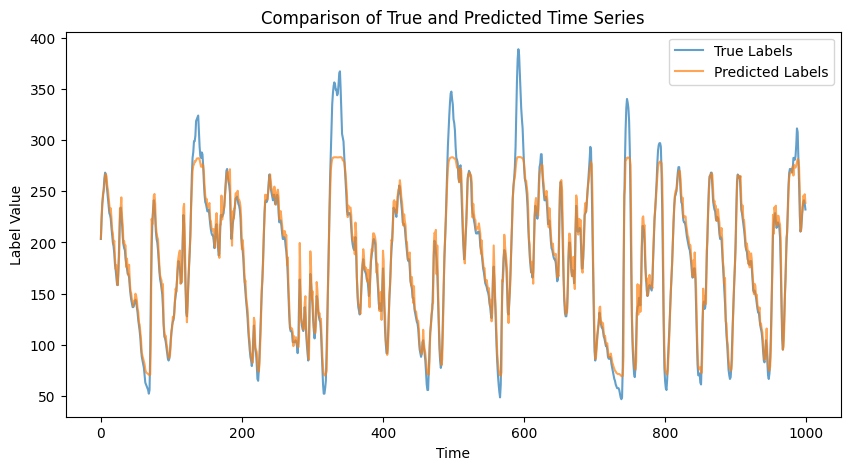

In [30]:
import matplotlib.pyplot as plt

# 画出比对图
plt.figure(figsize=(10, 5))
plt.plot(all_targets[-1000:], label='True Labels', alpha=0.7)
plt.plot(all_predictions[-1000:], label='Predicted Labels', alpha=0.7)
plt.legend()
plt.title('Comparison of True and Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Label Value')
plt.show()

In [32]:
targets_case=all_targets[-1000:]
predictions_case=all_predictions[-1000:]

# 找到同一位置，两者相差50以上的targets_case的值与位置
indexs = []
for i in range(len(targets_case)):
    if abs(targets_case[i]-predictions_case[i])>40:
        indexs.append(i)
        print(i,targets_case[i],predictions_case[i])


137 322.2 282.05972
138 324.0 282.18997
328 334.8 281.4105
329 345.6 282.83026
330 352.8 283.0912
331 356.4 283.20285
332 354.6 283.24463
333 349.2 283.22424
334 349.2 283.15063
335 343.8 283.15112
336 345.6 283.05222
337 354.6 283.08936
338 365.4 283.22504
339 367.2 283.3211
340 349.2 283.3324
341 327.6 283.1498
494 324.0 281.10864
495 336.6 282.3373
496 345.6 282.8756
497 347.4 283.0908
498 340.2 283.12186
499 334.8 283.2116
568 113.4 72.99871
589 324.0 278.60608
590 358.2 282.403
591 379.8 283.35486
592 388.8 283.38956
593 383.4 283.41382
594 365.4 283.40042
595 345.6 283.32056
596 331.2 283.08688
741 163.8 88.62974
745 331.2 280.88483
746 340.2 282.7032
747 336.6 282.9726
748 331.2 282.8667
752 172.8 213.66263


### 试一下shap value

In [43]:
import shap
shap.initjs()

# 将数据和模型移动到CPU
dataX_tensor_cpu = dataX_tensor.cpu()
model_cpu = model.cpu()

# 用于解释模型的SHAP解释器
explainer = shap.DeepExplainer(model_cpu, dataX_tensor_cpu)
shap_values = explainer.shap_values(dataX_tensor_cpu)

d:\Anaconda\envs\transformers\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [ ]:
shap.summary_plot(shap_values, dataX_tensor_cpu, max_display = 10)